# 환경 준비

In [30]:
!pip uninstall -y langchain-classic

Found existing installation: langchain-classic 1.0.1
Uninstalling langchain-classic-1.0.1:
  Successfully uninstalled langchain-classic-1.0.1


In [1]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.3.*" "langchain-huggingface" "huggingface_hub" "sentence-transformers" wikipedia -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.2/457.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 whi

In [2]:
!pip install chromadb google-search-results -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 구글 드라이브 연결

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 라이브러리 로딩

In [4]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain.chains import RetrievalQA
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

## API 확인

In [5]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/langchain/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

In [ ]:
print(os.environ['HF_TOKEN'][:40])

# RAG1 : 간단한 RAG 구성하기

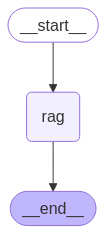

## state 정의

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Vector DB

OpenAI

In [ ]:
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
file_name = "sample.csv"
csv_loader = CSVLoader(file_path= path + file_name)
documents_csv = csv_loader.load()

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db")

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

Huggingface

In [ ]:
from langchain_community.document_loaders import CSVLoader
from langchain_huggingface import HuggingFaceEmbeddings # OpenAI 대신 사용
from langchain_community.vectorstores import Chroma

# 1. CSV 파일 로드
file_name = "sample.csv"
csv_loader = CSVLoader(file_path= path + file_name)
documents_csv = csv_loader.load()

# 2. 벡터 DB 정의 (HuggingFace 버전)
# 모델명 "jhgan/ko-sroberta-multitask"는 한국어 문장 임베딩에 널리 쓰이는 성능 좋은 모델입니다.
model_name = "jhgan/ko-sroberta-multitask"
model_kwargs = {'device': 'cpu'} # GPU 사용 시 'cuda'로 변경
encode_kwargs = {'normalize_embeddings': True} # 코사인 유사도 계산을 위해 정규화 권장

embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 3. Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents_csv,
    embedding,
    persist_directory= path + "chroma_db"
)

# 4. 리트리버 설정
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Hugging Face 임베딩 모델 (sentence-transformers 기반)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 3. Chroma DB 생성
vectorstore = Chroma.from_documents(
    documents_csv,
    embedding,
    persist_directory= path + "chroma_db"
)

## Node 정의

* RAG 노드
    * 최근 사용자의 질문을 꺼내서
    * RAG 체인으로 답변을 얻고
    * 새로운 GPT 응답 메시지를 state["messages"]에 추가하는 역할

OpenAI

In [ ]:
# RAG Chain
llm = ChatOpenAI(model="gpt-4.1-mini")
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

HuggingFace

In [10]:
# llm = ChatOpenAI(model="gpt-4.1-mini")  # 언어 모델을 gpt-4.1-mini로 설정
# HuggingFace에서 해당 모델을 불러오는 엔드포인트 지정
llm_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")

# HuggingFace에서 가져온 모델을 그대로 쓰지 않고,
# LangChain에서 쉽게 쓰도록 감싸는(wrapper) 단계
llm = ChatHuggingFace(llm=llm_ep)
rag_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

In [11]:
# RAG 노드 정의
def rag_node(state: State):
    # 메시지 리스트 중에서 HumanMessage (사용자 질문) 만 골라냄. m.content로 텍스트만 추출. [-1]: 가장 마지막 메시지를 선택
    user_msg = [m.content for m in state["messages"] if isinstance(m, HumanMessage)][-1]
    answer = rag_chain.invoke({"query": user_msg})  # RetrievalQA 함수는 입력으로 {"query": user_msg} 형태를 요구
    return {"messages": [AIMessage(content=answer["result"])]}

## 그래프 정의

In [12]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("rag", rag_node)

# connect nodes
builder.add_edge(START, "rag")
builder.add_edge("rag", END)

# compile the graph
graph = builder.compile()

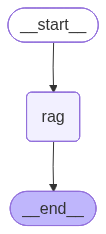

In [15]:
graph

## Graph 실행

In [23]:
# LangGraph를 0.3대 대응 버전으로 업데이트 (현재 기준 최신 버전 설치)
!pip install -U "langchain>=0.3" "langchain-core>=0.3" "langchain-community>=0.3" "langgraph>=0.3" "langchain-huggingface" "huggingface_hub" "sentence-transformers" wikipedia -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.35 requires langchain-core<1.0.0,>=0.3.78, but you have langchain-core 1.2.6 which is incompatible.


In [13]:
result = graph.invoke({"messages": [HumanMessage(content="보안 위협 중 가장 중대한 것이 무엇인가요?")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

보안 위협 중 가장 중대한 것이 무엇인가요?
================================== Ai Message ==================================

가장 중대한 보안 위협은 **데이터와 모델(가중치) 오염 공격**이라고 할 수 있습니다.  

1. **왜 중요한가?**  
   * 한 번 모델이 오염되면 그 모델을 사용하는 모든 애플리케이션·서비스가 동시에 위험에 노출됩니다.  
   * 공격자는 악의적 코드, 가짜 뉴스, 잘못된 정보를 학습 데이터에 삽입하거나 재학습(리트레이닝) 과정을 통해 모델 자체를 변형할 수 있습니다.  
   * 오염된 모델은 사후에 디버깅하기 어려우며, 재배포·업데이트될 때마다 같은 취약점을 그대로 전파합니다.

2. **대응이 어려운 이유**  
   * 학습 데이터가 공개되지 않거나 내부에서만 관리되는 경우, 누가, 언제, 어떤 데이터가 삽입됐는지 파악하기 어렵습니다.  
   * 모델 가중치 자체를 조작하면 외부에서 모델을 그대로 가져가 재학습 없이 바로 악용할 수 있습니다.

3. **비교**  
   * **시스템 프롬프트 침해**는 보안 메커니즘을 우회하는 강력한 공격이지만, 대부분의 기업이 프롬프트를 외부에 노출시키지 않으므로 접근성이 상대적으로 낮습니다.  
   * **소프트웨어에 악성 코드 삽입**은 개발 단계에서 일어나는 일인데, 이는 이미 개발 환경이 손상된 상황을 전제로 합니다.  
   * 반면, 데이터와 모델 오염은 한 번 발생하면 지속적으로 그리고 광범위하게 영향을 미치므로 가장 큰 위협으로 평가됩니다.

따라서 생성형 AI 프로젝트에서 가장 중대한 보안 위험은 **데이터와 모델 가중치를 조작하거나 오염시키는 공격**이라고 보는 것이 일반적입니다. 이 위협을 완화하려면 데이터 기증, 학습 프로세스, 모델 배포 단계에서

# RAG2 : VectorDB를 Tool로 사용하기

**구축절차**
1. Vector DB 준비 :  
2. Tool 정의 : Vector DB로 부터 검색하는 함수를 툴로 정의
3. LLM+Tool 바인딩
4. 노드 준비 & 분기 함수
5. 그래프 구성

In [14]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain.tools.render import render_text_description
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langgraph.prebuilt import ToolNode

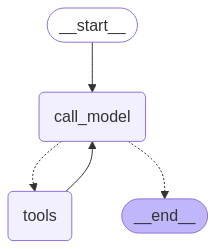

## Vector DB 준비

OpenAI

In [ ]:
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()

# 벡터 DB 정의
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db01")

retriever = vector_db.as_retriever(search_kwargs={"k": 3})

HuggingFace

In [16]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()
# Hugging Face 임베딩 모델 (sentence-transformers 기반)
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db01")
retriever = vector_db.as_retriever(search_kwargs={"k": 3})
print("ChromaDB에 저장 완료!")

/tmp/ipython-input-3104091551.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

ChromaDB에 저장 완료!


In [17]:
retriever.get_relevant_documents("보안 위협 중 가장 중대한 것이 무엇인가요?")

/tmp/ipython-input-992201062.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("보안 위협 중 가장 중대한 것이 무엇인가요?")


[Document(metadata={'row': 3, 'source': '/content/drive/MyDrive/langchain/sample.csv'}, page_content='\ufeff구분: 전문성 부족\n내용: 업계 전체에 전문성이 부족하다는 점은 새로운 문제를 야기한다. 원래 오픈소스의 장점 중 하나는 수많은 사람이 코드를 살펴보고 프로그래밍 오류, 보안 취약점 및 기타 약점을 발견할 수 있다는 부분이다. 마치 외부의 ‘천개의 눈’으로 문제점을 공동으로 확인하는 셈이다. 기존의 오픈소스 소프트웨어야 수많은 전문가가 있어 천개의 눈을 가질 수 있었지만 AI 분야에서는 전문가가 부족하다. 천개의 눈을 아직 모으지 못했으니 보안 취약점에 제대로 대응하지 못할 수도 있다.'),
 Document(metadata={'source': '/content/drive/MyDrive/langchain/sample.csv', 'row': 7}, page_content='\ufeff구분: 학습 데이터가 가진 위험\n내용: 노탈의 수기스는 “대형 벤더는 학습 데이터를 구입하고 소송을 벌이는 데 쓸 돈이 있을 뿐만 아니라, 선별된 데이터 세트에 쓸 돈도 있다”라고 설명했다. 무료로 공개된 데이터 세트에는 합법적인 콘텐츠만 있는 것이 아니다. 일부는 저작권이 있는데 허가 없이 포함된 상태일 수 있다. 거기다 부정확하고 편향된 정보, 멀웨어 및 출력 품질을 저하시킬 수 있는 기타 자료도 들어가 있다.\n수기스는 “많은 모델 개발자가 큐레이션된 데이터를 사용하자고 이야기하고 있다”라며 “하지만 그렇게 하려면 인터넷 전체를 학습시키는 것보다 비용이 더 많이 든다”라고 밝혔다.'),
 Document(metadata={'row': 5, 'source': '/content/drive/MyDrive/langchain/sample.csv'}, page_content='\ufeff구분: 탈옥\n내용: 반면에 악의적인 공격자는 접근하기 쉬운 오픈소스 모델을 무료로 다운로드하여 자신의 환경에

## Tool 정의

In [18]:
@tool
def vectordb_search(query: str) -> str:
    """내장 문서로부터 관련 정보를 검색합니다."""  # docstring 꼭 포함되어야 함!
    # 유사도 기준으로 상위 k개 문서를 벡터스토어에서 검색
    docs = retriever.get_relevant_documents(query)

    # 검색된 문서 내용들을 줄바꿈으로 구분하여 하나의 문자열로 반환
    return "\n\n".join(d.page_content for d in docs)

# tool 리스트
tools = [vectordb_search]

# 툴 실행 노드 (LangGraph 제공)
tool_node = ToolNode(tools)

## LLM + Tool 바인딩

OpenAI

In [ ]:
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).bind_tools(tools)

HuggingFace

In [19]:
hf_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")
llm = ChatHuggingFace(llm=hf_ep).bind_tools(tools)

## 노드 준비 & 분기 함수

In [20]:
# GPT 호출 노드
def call_model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

# 툴 사용 여부 판단
def should_continue(state: State) -> Literal["tools", END]:
    last = state["messages"][-1]            # 대화의 가장 마지막 객체(가장 최근 대화)
    if getattr(last, "tool_calls", None):   # last에서 tool_calls 내용이 포함되면, 'tool_calls', 아니면 None
        return "tools"
    return END

## 그래프 구성

In [21]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# connect nodes
builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")

graph = builder.compile()

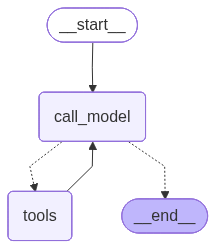

In [22]:
graph

## 실행

In [23]:
result = graph.invoke({"messages": [HumanMessage(content="LangGraph는 무엇인가요?")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

LangGraph는 무엇인가요?
================================== Ai Message ==================================

## LangGraph(언어 그래프)란?

**LangGraph**는 LLM(대형 언어 모델) 기반 워크플로를 **그래프(Directed Acyclic Graph, DAG) 형태**로 설계·실행해 주는 오픈소스 라이브러리입니다.  
LangChain의 파생 프로젝트이지만, **“노드 → 엣지 → 상태(state)”**라는 추상화 모델을 도입해 복잡한 다단계 작업을 쉽게 정의하고 재사용할 수 있도록 설계되었습니다.

> **핵심 아이디어**  
> 1️⃣ *상태(state)*는 딕셔너리 형태(예: `{'input': '텍스트', 'output': None}`)로 전달됩니다.  
> 2️⃣ *노드(node)*는 이 상태를 받아서 LLM 호출, 도구 호출, 후처리 등 하나의 작업을 수행하고 **다음 상태를 반환**합니다.  
> 3️⃣ *엣지(edge)*는 어떤 조건이 만족될 때 어떤 노드로 이동할지 정의합니다.  
> 4️⃣ *그래프(graph)*는 이 모든 노드·엣지를 연결해 전체 흐름을 한눈에 보며 실행할 수 있게 해 줍니다.

---

## 왜 LangGraph를 쓰나요?

| Feature | 기존 LangChain 방식 | LangGraph 방식 |
|---------|---------------------|----------------|
| **워크플로 정의** | Chain / Runnable / Agent 클래스(직렬/순차) | 노드(함수) + 엣지(조건/병렬) |
| **동적 흐름** | `if/else` 로직이 한곳에 몰림 | 그래프 구조(조건/루프/병렬)을 시각적으로 표현 |
| **상태 관리** | 각 단계마다 매번 변수를